<a href="https://colab.research.google.com/github/camayli/Trabajo-Final-Aprendiza-Autom-tico-II-/blob/main/Modelo_N%C2%B01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Instalar dependencias
!pip install -q kagglehub[pandas-datasets]

In [14]:
#Imports
import kagglehub
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.impute import KNNImputer
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report
)
from sklearn.inspection import permutation_importance
from kagglehub import KaggleDatasetAdapter

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline


In [3]:
#Path del archivo dentro del dataset
# En este dataset el archivo se llama:
file_path = "water_potability.csv"

In [4]:
#Cargar el dataset en un DataFrame de pandas
df = kagglehub.load_dataset(
    KaggleDatasetAdapter.PANDAS,
    "adityakadiwal/water-potability",
    file_path,
)

/tmp/ipython-input-1094881359.py:2: DeprecationWarning: Use dataset_load() instead of load_dataset(). load_dataset() will be removed in a future version.
  df = kagglehub.load_dataset(


100%|██████████| 513k/513k [00:00<00:00, 569kB/s]


In [5]:
#Verificar carga
df.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2785 non-null   float64
 1   Hardness         3276 non-null   float64
 2   Solids           3276 non-null   float64
 3   Chloramines      3276 non-null   float64
 4   Sulfate          2495 non-null   float64
 5   Conductivity     3276 non-null   float64
 6   Organic_carbon   3276 non-null   float64
 7   Trihalomethanes  3114 non-null   float64
 8   Turbidity        3276 non-null   float64
 9   Potability       3276 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 256.1 KB


In [7]:
df.shape

(3276, 10)

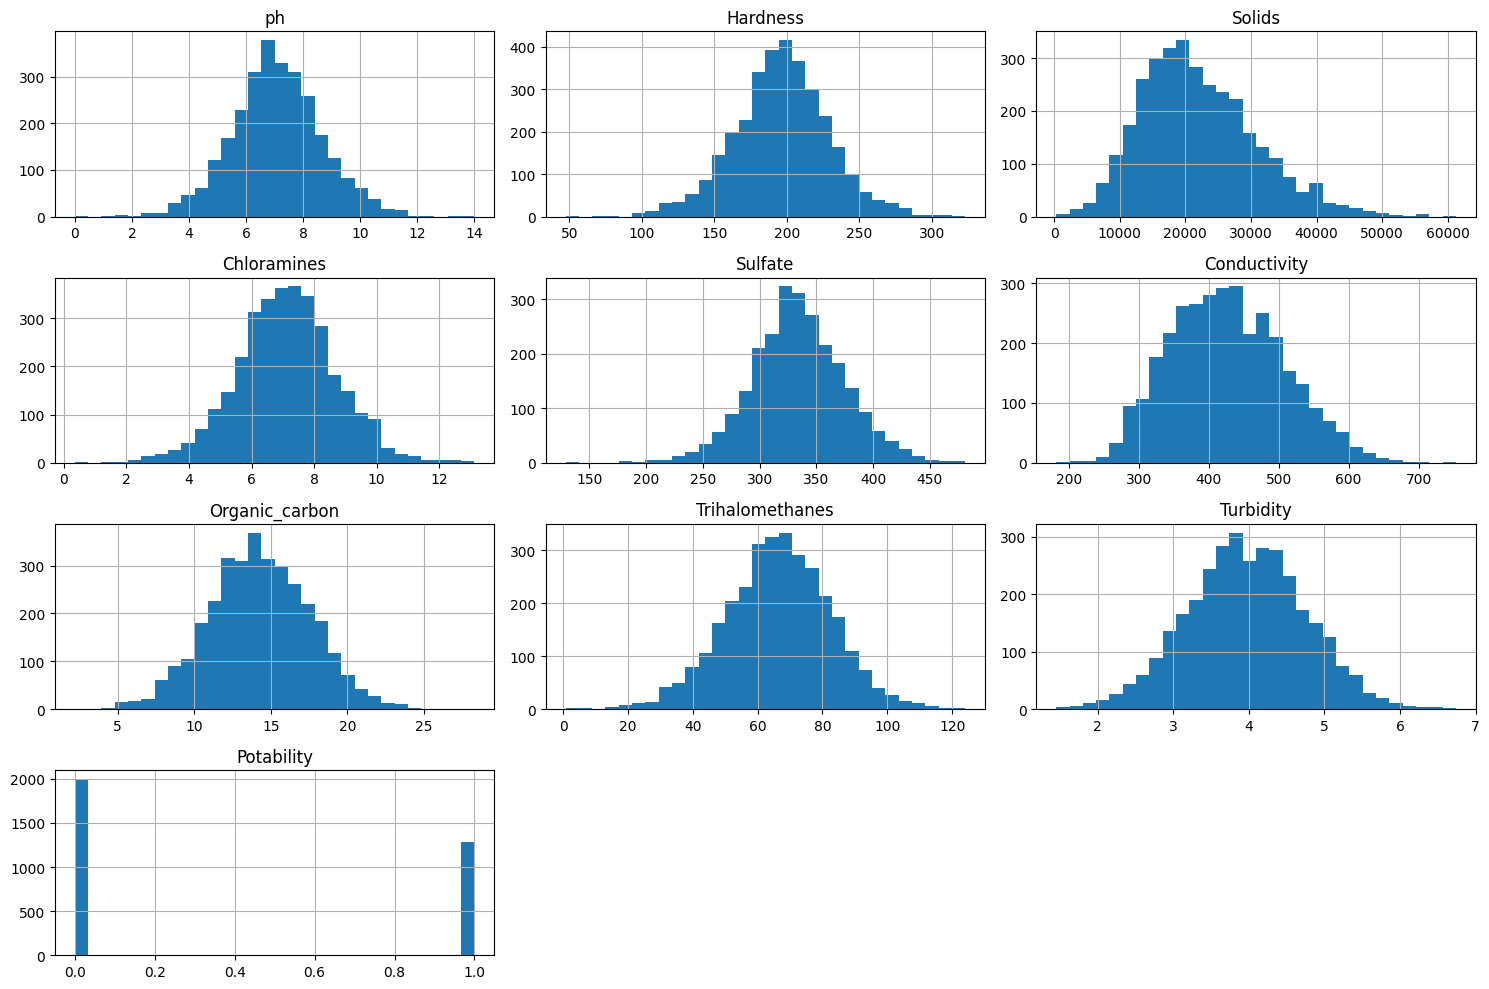

In [8]:
import matplotlib.pyplot as plt

df.hist(bins=30, figsize=(15, 10))
plt.tight_layout()
plt.show()

In [9]:
df.describe()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
count,2785.000000,3276.000000,3276.000000,3276.000000,2495.000000,3276.000000,3276.000000,3114.000000,3276.000000,3276.000000
mean,7.080795,196.369496,22014.092526,7.122277,333.775777,426.205111,14.284970,66.396293,3.966786,0.390110
std,1.594320,32.879761,8768.570828,1.583085,41.416840,80.824064,3.308162,16.175008,0.780382,0.487849
min,0.000000,47.432000,320.942611,0.352000,129.000000,181.483754,2.200000,0.738000,1.450000,0.000000
25%,6.093092,176.850538,15666.690297,6.127421,307.699498,365.734414,12.065801,55.844536,3.439711,0.000000
50%,7.036752,196.967627,20927.833607,7.130299,333.073546,421.884968,14.218338,66.622485,3.955028,0.000000
75%,8.062066,216.667456,27332.762127,8.114887,359.950170,481.792304,16.557652,77.337473,4.500320,1.000000
max,14.000000,323.124000,61227.196008,13.127000,481.030642,753.342620,28.300000,124.000000,6.739000,1.000000


In [10]:
X = df.drop(columns='Potability')
y = df['Potability']

In [13]:
# 2) Separar características (X) y variable objetivo (y)
y = df["Potability"]
X = df.drop("Potability", axis=1)

print("Shape X:", X.shape)
print("Shape y:", y.shape)
print("\nClases (conteo):\n", y.value_counts())

Shape X: (3276, 9)
Shape y: (3276,)

Clases (conteo):
 Potability
0    1998
1    1278
Name: count, dtype: int64


In [15]:
# 3) Preprocesamiento (Limpieza): Imputación de nulos (KNN)
# Importante (para cumplir guías): NO hacemos fit del imputador con todo el dataset.
# Definimos el KNNImputer y se entrenará SOLO con TRAIN (y en CV, por fold) dentro del Pipeline.
imputer = KNNImputer(n_neighbors=5)

print("\nNulos por columna (antes de imputar):")
print(X.isna().sum().sort_values(ascending=False))


Nulos por columna (antes de imputar):
Sulfate            781
ph                 491
Trihalomethanes    162
Solids               0
Hardness             0
Chloramines          0
Conductivity         0
Organic_carbon       0
Turbidity            0
dtype: int64


In [16]:
# 4) Preprocesamiento (Ingeniería de Características):
#    Estudio y tratamiento del balanceo de clases
####Diagnostico de balanceo
print("\nDistribución de clases (global):")
print(y.value_counts())
print("\nProporción global:")
print(y.value_counts(normalize=True))


Distribución de clases (global):
Potability
0    1998
1    1278
Name: count, dtype: int64

Proporción global:
Potability
0    0.60989
1    0.39011
Name: proportion, dtype: float64


En este dataset específico, la distribución de clases suele ser aproximadamente:

No Potable (0): ~61%

Potable (1): ~39%

In [17]:
#Regla de Decisión (Heurística)
##Qué hace: Calcula la diferencia entre la clase mayoritaria y la minoritaria.
##La regla: Si la diferencia es menor al 10% (0.10), el código decide automáticamente que el dataset SÍ está balanceado.
##Resultado: La variable balanced será True o False.
props = y.value_counts(normalize=True)
balanced = (props.max() - props.min()) < 0.10
print("\n¿Balanceado (heurística <10% diferencia)?", balanced)



¿Balanceado (heurística <10% diferencia)? False


In [20]:
#Viendo que esta desbalanceado asignamos directamente SMOTE a la variable

#Seed
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

#Estudio y tratamiento del balanceo de clases
print("\nDistribución de clases (global):")
print(y.value_counts())
print("\nProporción global:")
print(y.value_counts(normalize=True))

# Water Potability está desbalanceado → aplicaremos SMOTE (solo en train/folds vía Pipeline)
sampler_step = SMOTE(random_state=RANDOM_STATE)


Distribución de clases (global):
Potability
0    1998
1    1278
Name: count, dtype: int64

Proporción global:
Potability
0    0.60989
1    0.39011
Name: proportion, dtype: float64


In [21]:
# 5) División de Datos: Separación en conjuntos de Entrenamiento y Prueba (Train/Test)

# Split antes de entrenar cualquier cosa (para evaluación honesta)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    random_state=RANDOM_STATE,
    stratify=y
)

print("\nShapes:")
print("X_train:", X_train.shape, "X_test:", X_test.shape)
print("y_train:", y_train.shape, "y_test:", y_test.shape)
print("\nProporción train:")
print(y_train.value_counts(normalize=True))
print("\nProporción test:")
print(y_test.value_counts(normalize=True))


Shapes:
X_train: (2620, 9) X_test: (656, 9)
y_train: (2620,) y_test: (656,)

Proporción train:
Potability
0    0.609924
1    0.390076
Name: proportion, dtype: float64

Proporción test:
Potability
0    0.609756
1    0.390244
Name: proportion, dtype: float64


In [23]:
# 6) Modelado (Selección y Ajuste): Validación cruzada y Búsqueda de Hiperparámetros
# ==============================================================================
# Pipeline: KNNImputer -> (SMOTE si aplica) -> Modelo
# El ImbPipeline sabe que el paso smote solo debe aplicarse al conjunto de entrenamiento durante la validación cruzada, nunca al conjunto de validación/test.
pipe = ImbPipeline(steps=[
    ("imputer", imputer),
    ("smote", sampler_step),
    ("model", RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1))
])


In [28]:
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)

#Al ser Stratified, asegura que en cada una de esas 3 divisiones se mantenga la misma proporción de clases (Potable vs No Potable) que en el original. Esto es vital en datasets desbalanceados


In [29]:
#Prueba todas las combinaciones posibles. Por ejemplo: Imputar con 3 vecinos + SMOTE con 5 vecinos + Random Forest de 100 árboles.
param_grid = {
    "imputer__n_neighbors": [3, 5, 7, 9],
    "smote__k_neighbors": [3, 5, 7],
    "model__n_estimators": [100, 300],
    "model__max_depth": [None, 10, 20],
    "model__min_samples_split": [2, 5],
    "model__min_samples_leaf": [1, 2],
}

In [30]:
#Calcula 5 métricas diferentes para que las veas, pero le dice al código: "Para decidir cuál es el mejor modelo,
scoring = {
    "accuracy": "accuracy",
    "precision": "precision",
    "recall": "recall",
    "f1": "f1",
    "roc_auc": "roc_auc",
}

In [31]:
#(Validación y GridSearch) con la de Tema 3_ Evaluación.pdf (Métricas), asegurando que el modelo final sea el más robusto posible matemáticamente.

%time
grid_search = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring=scoring,
    refit="roc_auc",
    cv=cv,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

print("\nMejores hiperparámetros:", grid_search.best_params_)
print("Mejor ROC AUC (CV):", grid_search.best_score_)

Fitting 3 folds for each of 288 candidates, totalling 864 fits

Mejores hiperparámetros: {'imputer__n_neighbors': 5, 'model__max_depth': None, 'model__min_samples_leaf': 2, 'model__min_samples_split': 2, 'model__n_estimators': 300, 'smote__k_neighbors': 7}
Mejor ROC AUC (CV): 0.6814170407567893
